# Part 1: A Cellular Automata Model

We are using Cellular Automata to simulate our model tp demonstrate the process of desertification control by growing certain desert plant.

## The phenomenon to be modeled and simulated

Suppose we are implementing desertification control by growing two types of desert plant in arid amd semi-arid area. Let's define three types of soil indicating three different degrees of desertification in desert area, that is, N(nondesertification), M(medium desertification), S(serious desertification). <br>
We are growing two types of plant. One is Salix Mongolica(Plant 1) and the other one is Haloxylon Ammondendron(Plant 2). They are different in survival rate in different land, as well as the power for improving and maintaining the quality of soil. Specifically, Plant 1 is more suitable on N and M land and have higher probability to help improve the quality of desertified soil. Plant 2 has higher survival rate on M and S land compared to Plant 1, but has lower probability to improve quality of soil. <br>
In this case, we will try either Salix Mongolica or Haloxylon Ammondedron in different type of desertified lands, and find out the best solution for desertification control. <br>
Under the assumption, we are trying to figure out the best plant for land in different degree of desertification, and calculate the speed of afforestation under certain survival rate and recovery/reversal rate. <br>

## Conceptual model

Let's try using a cellular automaton as the conceptual model. <br>
Let's say the world is an $n\times n$ grid $G=G(t) \equiv (g_{ij}(t))$ of cells. The cells vary over discrete time interval of months or years. <br>
Every cell of G is a fraction of land with a type of three types of soil that is either N or M or S, and is either empty or occupied by a plant, therefore, a cell will have 6 states as follows: <br>
1. NE: Non-desertified, empty land
2. ME: Medium-desertified, empty land
3. SE: Serious-desertified, empty land
4. NV: Non-desertified land with vegetation
5. MV: Medium-desertified land with vegetation
6. SV: Serious-desertified land with vegetation

In [16]:
# Possible states:
EDGE = 0
SE = 1
ME = 2
NE = 3
SV = 4
MV = 5
NV = 6

Based on our assumption, we'll have these effects from soil or plants to the degree of desertification.

### Effects between soil and plant:

When time evolves, the cell will be in one of these states. And they are transitng with the effects below. <br>

Soil to plant:
1. Plant 1 has survival rate $r_1$.
2. Plant 2 has survival rate $r_2$.

Plant to soil:
1. When the plant survives, it will improve the quality of soil in conversion rate $c_1 \neq c_2$
3. If the plant dies, the cell wll become empty again.

Soil to soil:
1. The quality of soil can be improved if over 3 of its neighbors are higher quality with prob $p_b$ and it's not empty.
4. The land might have more severe desetification(lower quality) if it remains empty and its neighbors are all empty, the probability is $p_w$.

Now let's set a initial version of parameters for our model.

In [17]:
# Model Parameters:
N = 10 # number of cells(the min space that can be occupied by a desert plant), representing the size of the desertified land
SURV_RATE = 0.8 # survival rate of plant, say Plant 2
PROB_WORSE = 0.5 # fixed probability of soil's worsening effect
PROB_BETTER = 0.3 # fixed probability of soil's neighbor-improving effect
RATE_CONV = 0.4 # conversion/recovery rate of plant, say Plant 2

Let's use a 2-D Numpy array to store and implement the grid defined above.

In [18]:
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import scipy as sp
import scipy.sparse

def count (G):
    """
    Counts the number of locations in a Numpy array, `G`
    """
    return len(np.where(G)[0])

def find (G):
    """
    Returns the set of locations of a NumPy array, `G`
    """
    assert type(G) is np.ndarray
    return {(i,j) for i,j in zip(*np.where(G))}

def not_array(G):
    """
    Returns 0 if the element is 1, 1 if the element is 0
    """
    [rows, cols] = G.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            G[i,j] = 1 - G[i,j]
    return G.astype(int)

To show the process of simulation, consider a simple case. <br>
On t=0, the land is initially empty for all cells with different portion of N, M and S. 
Initially, let's say the land is a med-desertified area, and we have the first plant grown in the middle of the area. The initial state can be shown in the plot. <br>
We also tried another type of initialization, planting from one of the corner of the area.

In [73]:
from random import seed
from random import random
    
def random_choice(seq, prob, k=1):
    """
    with given prob, choose elements randomly from seq, can be done k times
    prob and seq must be in same size, sum(prob)=1
    default k=1
    return list
        >>> random_choice(['a','b','c','d'], [0.4, 0.15, 0.1, 0.35])
        ['d']
        >>> random_choice('abcd', [0.4, 0.15, 0.1, 0.35], k=5)
        ['d','d','b','a','d']
    """
    sum_prob = 0
    for i in range(len(prob)):
        sum_prob += prob[i]
    assert sum_prob == 1
    
    res = []
    for j in range(k):
        p = random()
        for i in range(len(seq)):
            if sum(prob[:i]) < p <= sum(prob[:i+1]):
                res.append(seq[i])
    return res


def create_world (n, emp, init):
    """
    Mid-point intialization
    """
    assert SE<=emp<=NE
    assert SV<=init<=NV
    G = np.zeros((n+2,n+2), dtype=int)
    G[1:-1, 1:-1] = emp
    i_mid = int ((n+2)/2)
    G[i_mid, i_mid] = init

    return G

def create_world_side(n, emp, init):
    
    assert SE<=emp<=NE
    assert SV<=init<=NV
    G = np.zeros((n+2,n+2), dtype=int)
    G[1:-1, 1:-1] = emp
    i_start = 1
    G[i_start, i_start] = init

    return G


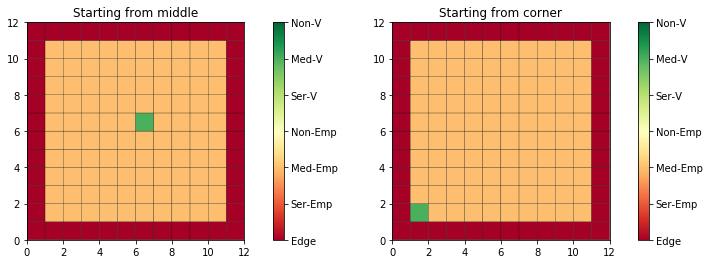

In [74]:
def show_world(G, vmin=EDGE, vmax=NV, values="states"):
    """
    Show the grid of CA simulation
    """
    assert values in ["states", "bool"]
    if values == "states":
        vticks = range(vmin, vmax+1)
        vlabels = ['Edge', 'Ser-Emp', 'Med-Emp', 'Non-Emp', 'Ser-V', 'Med-V', 'Non-V']
    else:
        vticks = [0,1]
        vlabels = ['False(0)', 'True(1)']
        
    m,n = G.shape[0]-2, G.shape[1]-2
    plt.pcolor(G, vmin=vmin, vmax=vmax, edgecolor='black')
    plt.set_cmap('RdYlGn')
    cb = plt.colorbar()
    cb.set_ticks (vticks)
    cb.set_ticklabels (vlabels)
    plt.axis('square')
    plt.axis([0, m+2, 0, n+2])
    

N=10
G_0 = create_world(N, ME, MV)
G_01 = create_world_side(N, ME, MV) 

fig = plt.figure (figsize=(12, 4))
plt.subplot (1, 2, 1)
show_world (G_0)
plt.title ('Starting from middle');

plt.subplot (1, 2, 2)
show_world (G_01)
plt.title ('Starting from corner');    

In [22]:
def non_emp (G):
    """
    Count the number of Nondesertified empty cells
    """
    return (G == NE).astype (int)
    
def med_emp (G):
    """
    Count the number of Med-desertified empty cells
    """
    return (G == ME).astype (int)
    
def ser_emp (G):
    """
    Count the number of Ser-desertified empty cells
    """
    return (G == SE).astype (int)
    
def non_v (G):
    """
    Count the number of Nondesertified cells covered with vegetation
    """
    return (G == NV).astype (int)
    
def med_v (G):
    """
    Count the number of Med-desertified cells covered with vegetation
    """
    return (G == MV).astype (int)
    
def ser_v (G):
    """
    Count the number of Ser-desertified cells covered with vegetation
    """
    return (G == SV).astype (int)


In [23]:
def exposed_to_greening (G):
    """
    Determines the cells for implantation of next step
    """
    E = np.zeros (G.shape, dtype=int) 
    I = ser_v(G)|med_v(G)|non_v(G)
    E[1:-1, 1:-1] = I[0:-2, 1:-1] | I[1:-1, 2:] | I[2:, 1:-1] | I[1:-1, 0:-2]
    return E


def exposed_to_better_neighbor(G):
    """
    Count the number of cells with neighbors who have less desertification level
    """
    E = np.zeros (G.shape, dtype=int) 
    [rows, cols] = G.shape
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if G[i,j] > NE:
                num_better = int(G[i-1,j]>G[i,j]) + int(G[i+1,j]>G[i,j]) + int(G[i,j-1]>G[i,j]) + int(G[i,j+1]>G[i,j])
                if (num_better >= 3):
                    E[i,j] = 1
    return E

def exposed_to_desert(G):
    """
    Count the number of cells that is empty and have empty neighbors
    """
    E = np.zeros (G.shape, dtype=int) 
    [rows, cols] = G.shape
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if G[i,j] <= NE:
                num_empty = int(G[i-1,j]<=NE) + int(G[i+1,j]<=NE) + int(G[i,j-1]<=NE) + int(G[i,j+1]<=NE)
                if (num_empty >= 4):
                    E[i,j] = 1
    return E


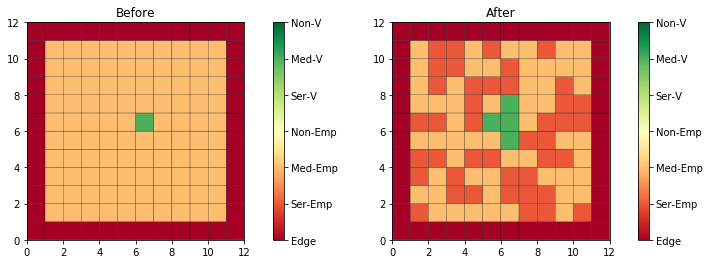

In [24]:

def survival (G, r = SURV_RATE):
    """
    Determines if the plant can survive with survival rate r
    """
    I = np.zeros (G.shape, dtype=int)
    I = ser_emp(G) | med_emp(G) | non_emp(G)
    random_draw = np.random.uniform (size=G.shape)
    G_s = (I) * exposed_to_greening (G) * (random_draw < r)
    return G_s.astype (int)  

        
def desertification(G, pw = PROB_WORSE):
    """
    Determines the number of more serious desertified cells
    """
    E = np.zeros (G.shape, dtype=int) 
    E = med_emp(G)|ser_emp(G)
    random_draw = np.random.uniform(size=G.shape)
    G_s = (E) * exposed_to_desert(G) * (random_draw < pw)
    return G_s.astype (int)    
    
def improved_neffect(G, pb = PROB_BETTER):
    """
    Determines the number of cells that will get better by neighbor-improving effect
    """
    S = np.zeros (G.shape, dtype=int) 
    S = med_v(G)|ser_v(G)
    random_draw = np.random.uniform(size=G.shape)
    G_s = (S) * exposed_to_better_neighbor(G) * (random_draw < pb)
    return G_s.astype (int) 



def improved_peffect(G, pv = RATE_CONV):
    """
    Determines the number of cells that will get better because of vegetation's recovery effect
    """
    S = np.zeros (G.shape, dtype=int) 
    S = med_v(G)|ser_v(G)
    random_draw = np.random.uniform(size=G.shape)
    G_s = (S) * (random_draw < pv)
    return G_s.astype (int) 


def sim_onestep(G, r = SURV_RATE, pw = PROB_WORSE, pb = PROB_BETTER, pv = RATE_CONV):
    # if the planted tree survives: plant trees around the cell
    # sim one step with desert worsening effect, neighbor-improving effect and vegetation's recovery effect
    
    [rows,cols] = G.shape
    G = G - desertification(G,pw) + improved_neffect(G,pb) + improved_peffect(G,pv)                
    P = survival(G, r)
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if P[i,j] == 1:
                if G[i,j] == NE:
                    G[i,j] = NV
                elif G[i,j] == ME:
                    G[i,j] = MV
                elif G[i,j] == SE:
                    G[i,j] = SV
    
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if G[i,j] == EDGE:
                G[i,j] = SE
            elif G[i,j] > NV:
                G[i,j] = NV
    return G

np.random.seed (1602034230) # Fixed seed, for debugging
G_1 = sim_onestep (G_0)

fig = plt.figure (figsize=(12, 4))
plt.subplot (1, 2, 1)
show_world (G_0)
plt.title ('Before');

plt.subplot (1, 2, 2)
show_world (G_1)
plt.title ('After');    
    

"Before" is the initial state of our sim world, while "After" shows the state after one-step simulation. <br>
To test the simulation, we run 10 steps below and the "After" plot shows the state of 10 steps forward in the simulation. Basicly, our simulation will stop when the whole area is non-desertified and covered with vegetations. Then we can compute an average time of stop to view the efficiency of the desertification control. At each step, we plant trees around the existing trees, for the surviving plant, there's probablity that the quality of soil will be improved by the vegetation itself or the vegetation of neighborhood, for those bald area, there's also probability that the desertification will be expanded. The greener the cell is, the smaller degree of desertification.<br>

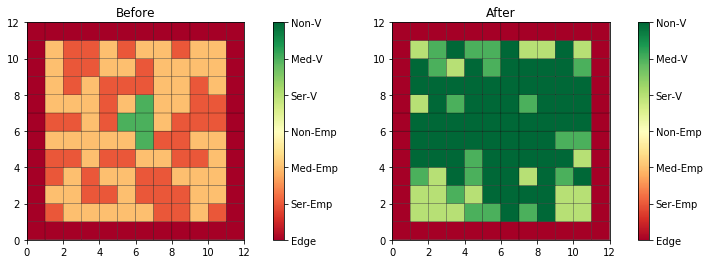

In [25]:
G_new = sim_onestep (G_0)
for i in range (1, 10):
    G_new = sim_onestep (G_new)    
   
fig = plt.figure (figsize=(12, 4))
plt.subplot (1, 2, 1)
show_world (G_1)
plt.title ('Before');

plt.subplot (1, 2, 2)
show_world (G_new)
plt.title ('After');    

## Simulation
Next, after the setup of model, we'll simulates to compare the two plants which are different on the survival rate and conversion rate. For example, we'll use the same setting as above, simulating on the Medium-desertified area with different survival rate and conversion rate. <br>
The parameters and the state at each step can be modified and observed as below. 

In [63]:
def summarize (G_t, verbose=True):
    """
    Summarizes the number of each state
    """
    n_NV = count (non_v (G_t))
    n_MV = count (med_v (G_t))
    n_SV = count (ser_v (G_t))
    n_NE = count (non_emp (G_t))
    n_ME = count (med_emp (G_t))
    n_SE = count (ser_emp (G_t))
    
    if verbose:
        print ("# Non-desertified with vegetation covered:", n_NV)
        print ("# Med-desertified with vegetation covered:", n_MV)
        print ("# Serious-desertified with vegetation covered:", n_SV)
        print ("# Non-desertified empty land:", n_NE)
        print ("# Med-desertified empty land:", n_ME)
        print ("# Serious-desertified empty land:", n_SE)
        
    return n_NV, n_MV, n_SV, n_NE, n_ME, n_SE 
    
def sim (G_0, max_steps, r = SURV_RATE, pw = PROB_WORSE, pb = PROB_BETTER, pv = RATE_CONV):
    """
    Starting from a given initial state, `G_0`, this
    function simulates up to `max_steps` time steps of
    the cellular automaton.
    """
    t, G_t = 0, G_0.copy ()
    [m,n] = G_t.shape[0]-2, G_t.shape[1]-2
    (num_NV, _, _, _, _, _) = summarize (G_t, verbose=False)
    while (num_NV < m*n) and (t < max_steps):
        t = t + 1
        G_t = sim_onestep (G_t, r)
        (num_NV, _, _, _, _, _) = summarize (G_t, verbose=False)
    return (t, G_t)


from ipywidgets import interact

def isim (n, max_steps=0, r = SURV_RATE, pw = PROB_WORSE, pb = PROB_BETTER, pv = RATE_CONV, seed=0):
    np.random.seed (seed)
    G_0 = np.zeros((n+2,n+2), dtype=int)
    G_0[1:-1, 1:-1] = ME
    i_mid = int ((n+2)/2)
    j_mid = int ((n+2)/2)
    G_0[i_mid, j_mid] = MV
    (_, G_t) = sim (G_0, max_steps, r, pw, pb, pv)
    show_world (G_t)
    
    
interact (isim
          , n=(1, 50, 1)
          , max_steps=(0, 100, 1)
          , r=(0.0, 1.0, 0.1)
          , pw=(0.0, 1.0, 0.1)
          , pb=(0.0, 1.0, 0.1)
          , pv=(0.0, 1.0, 0.1)
          , seed=(0, 50, 1)
         );


interactive(children=(IntSlider(value=25, description='n', max=50, min=1), IntSlider(value=0, description='max…

In [64]:
# === Simulation parameters ===

N = 25 # World is N x N
SURV_RATE = 0.5
PROB_WORSE = 0.5
PROB_BETTER = 0.3
RATE_CONV = 0.6
MAX_STEPS = 60
NUM_SIMS = 100

# === Holds simulation results ===
nNV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nMV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nNE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nME = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
T_stop = np.zeros (NUM_SIMS)

# === Define initial condition ===
G_0 = create_world(N, ME, MV)


# === Simulation ===

def sim_once (G_0, r = SURV_RATE, pw = PROB_WORSE, pb = PROB_BETTER, pv = RATE_CONV, t_max=MAX_STEPS):
    nNV = np.zeros (t_max+1)
    nMV = np.zeros (t_max+1)
    nSV = np.zeros (t_max+1)
    nNE = np.zeros (t_max+1)
    nME = np.zeros (t_max+1)
    nSE = np.zeros (t_max+1)
    
    nNV[0], nMV[0], nSV[0], nNE[0], nME[0], nSE[0] = summarize (G_0, verbose=False)
    t, G_t = 0, G_0.copy ()
    [m, n] = G_0.shape[0]-2, G_0.shape[1]-2
    while (nNV[t] < m*n) and (t < t_max):
        t, G_t = t+1, sim_onestep (G_t, r, pw, pb, pv)
        nNV[t], nMV[t], nSV[t], nNE[t], nME[t], nSE[t] = summarize (G_t, verbose=False)

    if t < MAX_STEPS: # Fill in steady-state values, if any
        nNV[t+1:] = nNV[t]
        nMV[t+1:] = nSV[t]
        nSV[t+1:] = nSV[t]
        nNE[t+1:] = nNE[t]
        nME[t+1:] = nSE[t]
        nSE[t+1:] = nSE[t]
        
    return t, nNV, nMV, nSV, nNE, nME, nSE

for k in range (NUM_SIMS):
    T_stop[k], nNV[:, k], nMV[:, k], nSV[:, k], nNE[:, k], nME[:, k], nSE[:, k] = sim_once (G_0, SURV_RATE, PROB_WORSE, PROB_BETTER, RATE_CONV, MAX_STEPS)


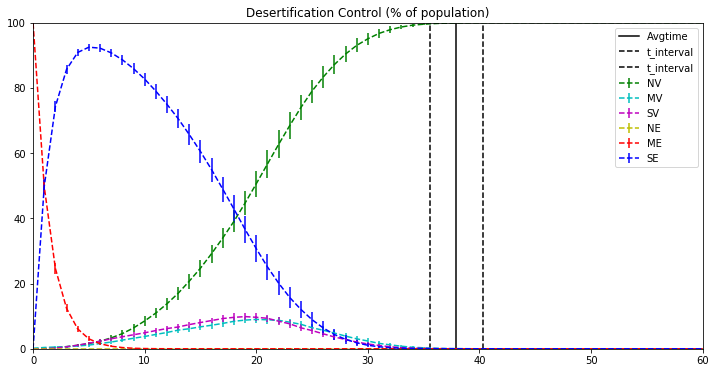

In [65]:
# === Visualize the sim results ===

# Computes the averages and stds
NV_avg = np.mean (nNV, axis=1)
MV_avg = np.mean (nMV, axis=1)
SV_avg = np.mean (nSV, axis=1)
NE_avg = np.mean (nNE, axis=1)
ME_avg = np.mean (nME, axis=1)
SE_avg = np.mean (nSE, axis=1)
t_stop_avg = np.mean (T_stop)

NV_std = np.std (nNV, axis=1)
MV_std = np.std (nMV, axis=1)
SV_std = np.std (nSV, axis=1)
NE_std = np.std (nNE, axis=1)
ME_std = np.std (nME, axis=1)
SE_std = np.std (nSE, axis=1)
t_stop_std = np.std (T_stop)

T = np.arange (MAX_STEPS+1)
fig = plt.figure (figsize=(12, 6))

SCALE = 1e2 / (N**2)
plt.errorbar (T, NV_avg*SCALE, yerr=NV_std*SCALE, fmt='g--')
plt.errorbar (T, MV_avg*SCALE, yerr=MV_std*SCALE, fmt='c--')
plt.errorbar (T, SV_avg*SCALE, yerr=SV_std*SCALE, fmt='m--')
plt.errorbar (T, NE_avg*SCALE, yerr=NE_std*SCALE, fmt='y--')
plt.errorbar (T, ME_avg*SCALE, yerr=ME_std*SCALE, fmt='r--')
plt.errorbar (T, SE_avg*SCALE, yerr=SE_std*SCALE, fmt='b--')
plt.plot ([t_stop_avg, t_stop_avg], [0., 100.], 'k-')
plt.plot ([t_stop_avg-t_stop_std, t_stop_avg-t_stop_std], [0., 100.], 'k--')
plt.plot ([t_stop_avg+t_stop_std, t_stop_avg+t_stop_std], [0., 100.], 'k--')
plt.axis ([0, MAX_STEPS, 0.0, 100.0])
plt.legend (['Avgtime' ,'t_interval', 't_interval', 'NV', 'MV', 'SV', 'NE', 'ME', 'SE'], loc=0)
plt.title ("Desertification Control (% of population)")

# Sanity check
assert (np.abs ((NV_avg + MV_avg + SV_avg + NE_avg + ME_avg + SE_avg)/(N**2) - 1.0) <= 1e-15).all ()

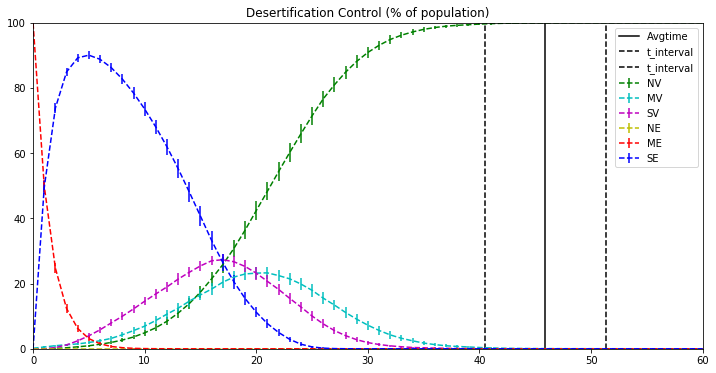

In [66]:
# === Simulation parameters ===

N = 25 # World is N x N
SURV_RATE = 0.7
PROB_WORSE = 0.5
PROB_BETTER = 0.3
RATE_CONV = 0.2
MAX_STEPS = 60
NUM_SIMS = 100

# === Holds simulation results ===
nNV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nMV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nNE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nME = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
T_stop = np.zeros (NUM_SIMS)

# === Define initial condition ===
G_0 = create_world(N, ME, MV)


# === Simulation ===

for k in range (NUM_SIMS):
    T_stop[k], nNV[:, k], nMV[:, k], nSV[:, k], nNE[:, k], nME[:, k], nSE[:, k] = sim_once (G_0, SURV_RATE, PROB_WORSE, PROB_BETTER, RATE_CONV, MAX_STEPS)

    
# === Visualize the sim results ===

# Computes the averages and stds
NV_avg = np.mean (nNV, axis=1)
MV_avg = np.mean (nMV, axis=1)
SV_avg = np.mean (nSV, axis=1)
NE_avg = np.mean (nNE, axis=1)
ME_avg = np.mean (nME, axis=1)
SE_avg = np.mean (nSE, axis=1)
t_stop_avg = np.mean (T_stop)

NV_std = np.std (nNV, axis=1)
MV_std = np.std (nMV, axis=1)
SV_std = np.std (nSV, axis=1)
NE_std = np.std (nNE, axis=1)
ME_std = np.std (nME, axis=1)
SE_std = np.std (nSE, axis=1)
t_stop_std = np.std (T_stop)

T = np.arange (MAX_STEPS+1)
fig = plt.figure (figsize=(12, 6))

SCALE = 1e2 / (N**2)
plt.errorbar (T, NV_avg*SCALE, yerr=NV_std*SCALE, fmt='g--')
plt.errorbar (T, MV_avg*SCALE, yerr=MV_std*SCALE, fmt='c--')
plt.errorbar (T, SV_avg*SCALE, yerr=SV_std*SCALE, fmt='m--')
plt.errorbar (T, NE_avg*SCALE, yerr=NE_std*SCALE, fmt='y--')
plt.errorbar (T, ME_avg*SCALE, yerr=ME_std*SCALE, fmt='r--')
plt.errorbar (T, SE_avg*SCALE, yerr=SE_std*SCALE, fmt='b--')
plt.plot ([t_stop_avg, t_stop_avg], [0., 100.], 'k-')
plt.plot ([t_stop_avg-t_stop_std, t_stop_avg-t_stop_std], [0., 100.], 'k--')
plt.plot ([t_stop_avg+t_stop_std, t_stop_avg+t_stop_std], [0., 100.], 'k--')
plt.axis ([0, MAX_STEPS, 0.0, 100.0])
plt.legend (['Avgtime' ,'t_interval', 't_interval','NV', 'MV', 'SV', 'NE', 'ME', 'SE'], loc=0)
plt.title ("Desertification Control (% of population)")

# Sanity check
assert (np.abs ((NV_avg + MV_avg + SV_avg + NE_avg + ME_avg + SE_avg)/(N**2) - 1.0) <= 1e-15).all ()


From the plot we can tell that based on our setting, there is a huge growing for serious-desertified empty area because of at the very beginning the area is exposed to empty and easily eroded circumstances, the desertification effect is strong. But once we begin the greening, the degree of desertification is soon suppressed to a lower level. Finally, the overall land will converge to a non-desertified area with vegetation. <br>
Comparing the simulation over Plant 1 and Plant 2 with preset parameters(survival rate of Plant 1 = 0.5 while the rate of Plant 2 = 0.7, the conversion rate of Plant 1 and Plant 2 is 0.6 and 0.2 respectively, and we fixed the $p_w$ and $p_b$ to be 0.5 and 0.3), we found that Plant 1 with higher conversion rate convergence faster (lower Avgtime), that is, the one with higher conversion rate and lower survival rate afforests the land quicker.<br>
Then in the following steps, we'll compare their effect on serious-desertified land with med-desertified land above.

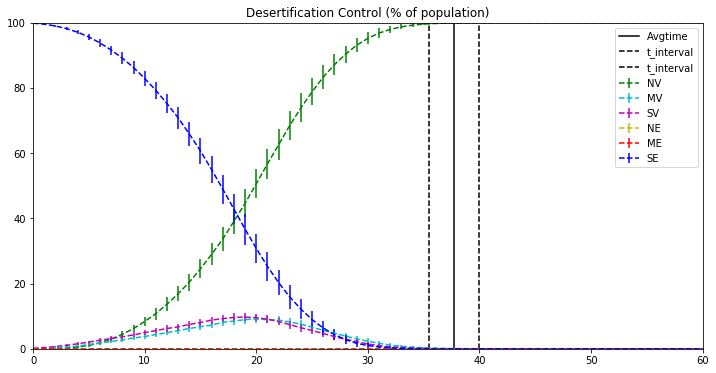

In [67]:
# === Simulation parameters ===

N = 25 # World is N x N
SURV_RATE = 0.5
PROB_WORSE = 0.5
PROB_BETTER = 0.3
RATE_CONV = 0.6
MAX_STEPS = 60
NUM_SIMS = 100

# === Holds simulation results ===
nNV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nMV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nNE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nME = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
T_stop = np.zeros (NUM_SIMS)

# === Define initial condition ===
G_0 = create_world(N, SE, SV)


# === Simulation ===

for k in range (NUM_SIMS):
    T_stop[k], nNV[:, k], nMV[:, k], nSV[:, k], nNE[:, k], nME[:, k], nSE[:, k] = sim_once (G_0, SURV_RATE, PROB_WORSE, PROB_BETTER, RATE_CONV, MAX_STEPS)

    
# === Visualize the sim results ===

# Computes the averages and stds
NV_avg = np.mean (nNV, axis=1)
MV_avg = np.mean (nMV, axis=1)
SV_avg = np.mean (nSV, axis=1)
NE_avg = np.mean (nNE, axis=1)
ME_avg = np.mean (nME, axis=1)
SE_avg = np.mean (nSE, axis=1)
t_stop_avg = np.mean (T_stop)

NV_std = np.std (nNV, axis=1)
MV_std = np.std (nMV, axis=1)
SV_std = np.std (nSV, axis=1)
NE_std = np.std (nNE, axis=1)
ME_std = np.std (nME, axis=1)
SE_std = np.std (nSE, axis=1)
t_stop_std = np.std (T_stop)

T = np.arange (MAX_STEPS+1)
fig = plt.figure (figsize=(12, 6))

SCALE = 1e2 / (N**2)
plt.errorbar (T, NV_avg*SCALE, yerr=NV_std*SCALE, fmt='g--')
plt.errorbar (T, MV_avg*SCALE, yerr=MV_std*SCALE, fmt='c--')
plt.errorbar (T, SV_avg*SCALE, yerr=SV_std*SCALE, fmt='m--')
plt.errorbar (T, NE_avg*SCALE, yerr=NE_std*SCALE, fmt='y--')
plt.errorbar (T, ME_avg*SCALE, yerr=ME_std*SCALE, fmt='r--')
plt.errorbar (T, SE_avg*SCALE, yerr=SE_std*SCALE, fmt='b--')
plt.plot ([t_stop_avg, t_stop_avg], [0., 100.], 'k-')
plt.plot ([t_stop_avg-t_stop_std, t_stop_avg-t_stop_std], [0., 100.], 'k--')
plt.plot ([t_stop_avg+t_stop_std, t_stop_avg+t_stop_std], [0., 100.], 'k--')
plt.axis ([0, MAX_STEPS, 0.0, 100.0])
plt.legend (['Avgtime' ,'t_interval', 't_interval','NV', 'MV', 'SV', 'NE', 'ME', 'SE'], loc=0)
plt.title ("Desertification Control (% of population)")

# Sanity check
assert (np.abs ((NV_avg + MV_avg + SV_avg + NE_avg + ME_avg + SE_avg)/(N**2) - 1.0) <= 1e-15).all ()


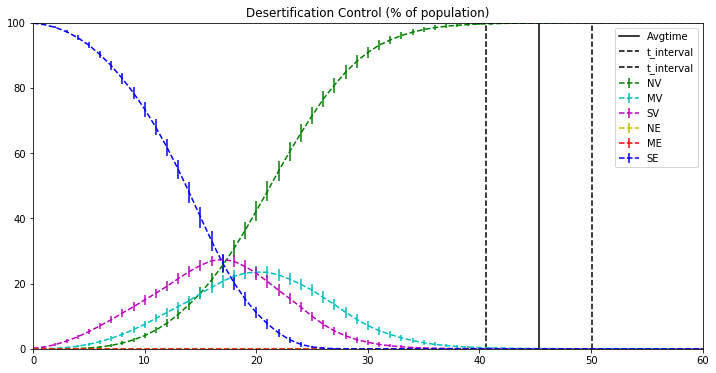

In [68]:
# === Simulation parameters ===

N = 25 # World is N x N
SURV_RATE = 0.7
PROB_WORSE = 0.5
PROB_BETTER = 0.3
RATE_CONV = 0.2
MAX_STEPS = 60
NUM_SIMS = 100

# === Holds simulation results ===
nNV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nMV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nNE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nME = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
T_stop = np.zeros (NUM_SIMS)

# === Define initial condition ===
G_0 = create_world(N, SE, SV)


# === Simulation ===

for k in range (NUM_SIMS):
    T_stop[k], nNV[:, k], nMV[:, k], nSV[:, k], nNE[:, k], nME[:, k], nSE[:, k] = sim_once (G_0, SURV_RATE, PROB_WORSE, PROB_BETTER, RATE_CONV, MAX_STEPS)

    
# === Visualize the sim results ===

# Computes the averages and stds
NV_avg = np.mean (nNV, axis=1)
MV_avg = np.mean (nMV, axis=1)
SV_avg = np.mean (nSV, axis=1)
NE_avg = np.mean (nNE, axis=1)
ME_avg = np.mean (nME, axis=1)
SE_avg = np.mean (nSE, axis=1)
t_stop_avg = np.mean (T_stop)

NV_std = np.std (nNV, axis=1)
MV_std = np.std (nMV, axis=1)
SV_std = np.std (nSV, axis=1)
NE_std = np.std (nNE, axis=1)
ME_std = np.std (nME, axis=1)
SE_std = np.std (nSE, axis=1)
t_stop_std = np.std (T_stop)

T = np.arange (MAX_STEPS+1)
fig = plt.figure (figsize=(12, 6))

SCALE = 1e2 / (N**2)
plt.errorbar (T, NV_avg*SCALE, yerr=NV_std*SCALE, fmt='g--')
plt.errorbar (T, MV_avg*SCALE, yerr=MV_std*SCALE, fmt='c--')
plt.errorbar (T, SV_avg*SCALE, yerr=SV_std*SCALE, fmt='m--')
plt.errorbar (T, NE_avg*SCALE, yerr=NE_std*SCALE, fmt='y--')
plt.errorbar (T, ME_avg*SCALE, yerr=ME_std*SCALE, fmt='r--')
plt.errorbar (T, SE_avg*SCALE, yerr=SE_std*SCALE, fmt='b--')
plt.plot ([t_stop_avg, t_stop_avg], [0., 100.], 'k-')
plt.plot ([t_stop_avg-t_stop_std, t_stop_avg-t_stop_std], [0., 100.], 'k--')
plt.plot ([t_stop_avg+t_stop_std, t_stop_avg+t_stop_std], [0., 100.], 'k--')
plt.axis ([0, MAX_STEPS, 0.0, 100.0])
plt.legend (['Avgtime' ,'t_interval', 't_interval','NV', 'MV', 'SV', 'NE', 'ME', 'SE'], loc=0)
plt.title ("Desertification Control (% of population)")

# Sanity check
assert (np.abs ((NV_avg + MV_avg + SV_avg + NE_avg + ME_avg + SE_avg)/(N**2) - 1.0) <= 1e-15).all ()


After comparing on med-desertified and serious-desertified land, we did not found much difference. Let's look at the different strategy on planting.

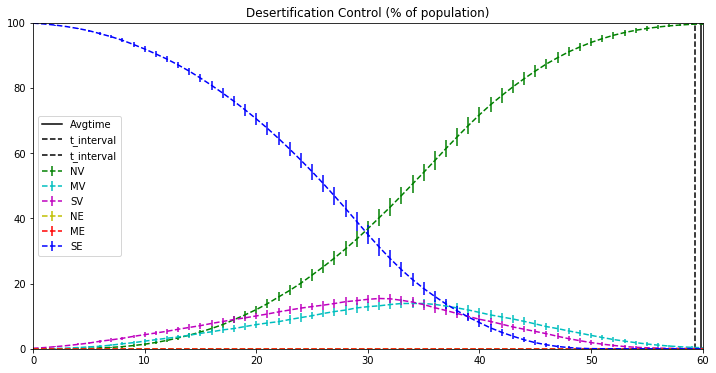

In [70]:
# === Simulation parameters ===

N = 25 # World is N x N
SURV_RATE = 0.7
PROB_WORSE = 0.5
PROB_BETTER = 0.3
RATE_CONV = 0.2
MAX_STEPS = 60
NUM_SIMS = 100

# === Holds simulation results ===
nNV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nMV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSV = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nNE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nME = np.zeros ((MAX_STEPS+1, NUM_SIMS))
nSE = np.zeros ((MAX_STEPS+1, NUM_SIMS))
T_stop = np.zeros (NUM_SIMS)

# === Define initial condition ===
G_0 = create_world_side(N, SE, SV)


# === Simulation ===

for k in range (NUM_SIMS):
    T_stop[k], nNV[:, k], nMV[:, k], nSV[:, k], nNE[:, k], nME[:, k], nSE[:, k] = sim_once (G_0, SURV_RATE, PROB_WORSE, PROB_BETTER, RATE_CONV, MAX_STEPS)

    
# === Visualize the sim results ===

# Computes the averages and stds
NV_avg = np.mean (nNV, axis=1)
MV_avg = np.mean (nMV, axis=1)
SV_avg = np.mean (nSV, axis=1)
NE_avg = np.mean (nNE, axis=1)
ME_avg = np.mean (nME, axis=1)
SE_avg = np.mean (nSE, axis=1)
t_stop_avg = np.mean (T_stop)

NV_std = np.std (nNV, axis=1)
MV_std = np.std (nMV, axis=1)
SV_std = np.std (nSV, axis=1)
NE_std = np.std (nNE, axis=1)
ME_std = np.std (nME, axis=1)
SE_std = np.std (nSE, axis=1)
t_stop_std = np.std (T_stop)

T = np.arange (MAX_STEPS+1)
fig = plt.figure (figsize=(12, 6))

SCALE = 1e2 / (N**2)
plt.errorbar (T, NV_avg*SCALE, yerr=NV_std*SCALE, fmt='g--')
plt.errorbar (T, MV_avg*SCALE, yerr=MV_std*SCALE, fmt='c--')
plt.errorbar (T, SV_avg*SCALE, yerr=SV_std*SCALE, fmt='m--')
plt.errorbar (T, NE_avg*SCALE, yerr=NE_std*SCALE, fmt='y--')
plt.errorbar (T, ME_avg*SCALE, yerr=ME_std*SCALE, fmt='r--')
plt.errorbar (T, SE_avg*SCALE, yerr=SE_std*SCALE, fmt='b--')
plt.plot ([t_stop_avg, t_stop_avg], [0., 100.], 'k-')
plt.plot ([t_stop_avg-t_stop_std, t_stop_avg-t_stop_std], [0., 100.], 'k--')
plt.plot ([t_stop_avg+t_stop_std, t_stop_avg+t_stop_std], [0., 100.], 'k--')
plt.axis ([0, MAX_STEPS, 0.0, 100.0])
plt.legend (['Avgtime' ,'t_interval', 't_interval','NV', 'MV', 'SV', 'NE', 'ME', 'SE'], loc=0)
plt.title ("Desertification Control (% of population)")

# Sanity check
assert (np.abs ((NV_avg + MV_avg + SV_avg + NE_avg + ME_avg + SE_avg)/(N**2) - 1.0) <= 1e-15).all ()


Using the parameters for Plant 2 and serious-desertification assumption, it's obvious that planting trees starting from the middle of the land is faster from starting from the corner. We can play around with this model with more variation such as the $p_b$ and $p_w$ can be changed due to the characteristics and location of the land, or imports more effects and settings to simulates the real world desertification control.